<a href="https://colab.research.google.com/github/seoyujiin/esaa_ob/blob/main/%ED%8C%8C%EB%A8%B8ch9_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**CHAPTER 9 추천 시스템**

###**05 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트**

TMDB 5000 영화 데이터 세트: 유명한 영화 데이터 정보 사이트인 IMDB의 많은 영화 중 주요 5000개 영화에 대한 메타 정보를 새롭게 가공한 데이터 세트

**장르 속성을 이용한 영화 콘텐츠 기반 필터링**

* 콘텐츠 기반 필터링은 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것
* 영화(또는 상품/서비스) 간의 유사성을 판단하는 기준이 영화를 구성하는 다양한 콘텐츠(장르, 감독, 배우, 평점, 키워드, 영화 설명)를 기반으로 하는 방식이 바로 콘텐츠 기반 필터링

**데이터 로딩 및 가공**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('/content/drive/MyDrive/ESAA/OB/data/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


→ tmdb_5000_movies.csv는 4803개의 레코드와 20개의 피처로 구성

→ 영화 제목, 개요, 인기도, 평점, 투표 수, 예산, 키워드 등 영화에 대한 다양한 메타 정보를 가지고 있음

In [ ]:
# 콘텐츠 기반 필터링 추천 분석에 사용할 주요 칼럼만 추출해 새롭게 DataFrame으로 만들기
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity',
                    'keywords', 'overview']]

→ 'genres', 'keywords' 등과 같은 칼럼은 파이썬 리스트 내부에 여러 개의 딕셔너리가 있는 형태의 문자열로 표기되어 있음

→ 이러한 칼럼을 가공하지 않고는 필요한 정보를 추출할 수 없음

In [ ]:
pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


→ genres 칼럼은 여러 개의 개별 장르 데이터를 가지고 있고, 이 개별 장르의 명칭은 딕셔너리의 키(Key)인 'name'으로 추출할 수 있음

→ keywords 역시 마찬가지 구조

In [ ]:
# genres 칼럼의 문자열 분해해서 개별 장르를 파이썬 리스트 객체로 추출
# 파이썬 ast 모듈의 literal_eval() 함수 이용하면 이 문자열을 문자열이 의미하는 list[dict1, dict2] 객체로 만들 수 있음
from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

→ 이제 genres 칼럼은 문자열이 아니라 실제 리스트 내부에 여러 장르 딕셔너리로 구성된 객체를 가짐

In [ ]:
# genres 칼럼에서 장르명만 리스트 객체로 추출
movies_df['genres'] = movies_df['genres'].apply(lambda x: [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: [y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


**장르 콘텐츠 유사도 측정**

* genres를 문자열로 변경한 뒤 이를 CountVectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교
* genres 칼럼을 기반으로 하는 콘텐츠 기반 필터링 구현 단계
  * 문자열로 변환된 genres 칼럼을 Count 기반으로 피처 벡터화 변환
  * genres 문자열을 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교. 이를 위해 데이터 세트의 레코드별로 타 레코드와 장르에서 코사인 유사도 값을 가지는 객체 생성
  * 장르 유사도가 높은 영화 중에 평점이 높은 순으로 영화를 추천

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환
# 리스트 객체 내의 개별 값을 연속된 문자열로 변환하려면 일반적으로 ('구분문자').join(리스트 객체) 사용
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x: (' ').join(x))
count_vect = CountVectorizer(min_df=0, ngram_range=(1, 2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


→ CountVectorizer로 변환해 4803개의 레코드와 276개의 개별 단어 피처로 구성된 피처 벡터 행렬 만들어짐

In [ ]:
# 생성된 피처 벡터 행렬에 사이킷런의 cosine_similarity() 이용해 코사인 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:1])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]]


→ cosine_similarity() 호출로 생성된 genre_sim 객체는 movies_df의 genre_literal 칼럼을 피처 벡터화한 행렬(genre_mat) 데이터의 행(레코드)별 유사도 정보를 가지고 있으며, 결국은 movies_df DataFrame의 행렬 장르 유사도 값을 가지고 있는 것

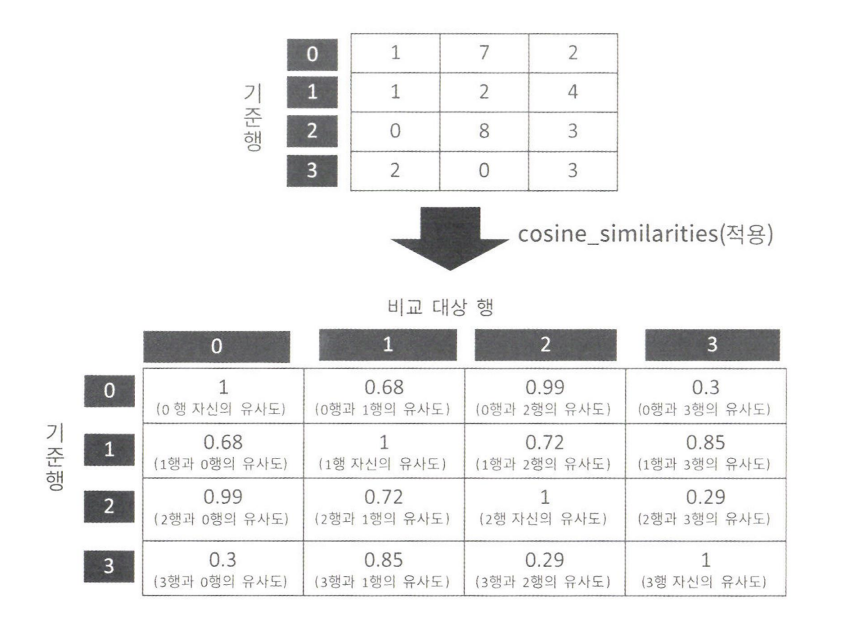

In [ ]:
# movies_df의 개별 레코드에 대해서 가장 장르 유사도가 높은 순으로 다른 레코드 추출
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


→ 0번 레코드의 경우 자신인 0번 레코드를 제외하면 3494번 레코드번 레코드가 가장 유사도가 높고, 그다음이 813번 레코드이며, 가장 유사도가 낮은 레코드는 2401번 레코드라는 뜻

**장르 콘텐츠 필터링을 이용한 영화 추천**

* 장르 유사도에 따라 영화를 추천하는 함수 생성
* 함수명: find_sim_movie()
  * 인자
    * 기반 데이터인 movies_df DataFrame
    * 레코드별 장르 코사인 유사도 인덱스를 가지고 있는 genre_sim_sorted_ind
    * 고객이 선정한 추천 기준이 되는 영화 제목
    * 추천할 영화 건수

In [ ]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
  title_movie = df[df['title'] == title_name]

  # title_named을 가진 DataFrame의 index 객체를 ndarray로 반환하고
  # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
  title_index = title_movie.index.values
  similar_indexes = sorted_ind[title_index, :(top_n)]

  # 추출된 top_n index 출력. top_n index는 2차원 데이터임
  # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

In [ ]:
# 영화 '대부'와 장르별로 유사한 영화 10개 추천
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


→ 좀 더 개선 필요

→ 좀 더 많은 후보군을 선정한 뒤에 영화의 평점에 따라 필터링해서 최종 추천하는 방식

→ 영화의 평점 정보인 'vote_average' 값 이용

→ vote_average는 0부터 10점 만점까지의 점수로 되어 있는데, 여러 관객이 평가한 평점을 평균한 것인데, 1명, 2명의 소수의 관객이 특정 영화에 만점이나 매우 높은 평점을 부여해 왜곡된 데이터를 가지고 있음

In [ ]:
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


→ '쇼생크 탈출'이나 '대부'같은 명작보다 높은 순위에 'Still Upper Lips', 'Me You and Five Bucks'와 같이 이름도 들어본 적 없는 영화가 더 높은 평점으로 있지만 이들은 모두 평가 횟수가 매우 작음

→ 이와 같은 왜곡된 평점 데이터를 회피할 수 있도록 평점에 평가 횟수를 반영할 수 있는 새로운 평가 방식 필요

→ 유명한 영화 평점 사이트인 IMDB에서는 평가 횟수에 대한 가중치가 부여된 평점(Weighted Rating) 방식 사용

* 가중 평점의 공식
$$
가중 평점\text{(Weighted Rating)} = \mathbf{(v/(v+m)) * R + (m/(v+m)) * C}
$$
  * v: 개별 영화에 평점을 투표한 횟수
  * m: 평점을 부여하기 위한 최소 투표 횟소
  * R: 개별 영화에 대한 평균 평점
  * C: 전체 영화에 대한 평균 평점

→ V는 movies_df의 'vote_count' 값이며, R 값은 'vote_average' 값에 해당

→ C의 경우 전체 영화의 평균 평점이므로 movies_df['vote_average'].mean()으로 구할 수 있음


In [ ]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)  # 전체 투표 횟수에서 상위 60%에 해당하는 횟수를 기준으로 정함
print('C:', round(C, 3), 'm:', round(m, 3))

C: 6.092 m: 370.2


In [ ]:
# 기존 평점을 새로운 가중 평점으로 변경하는 함수 생성하고 이를 이용해 새로운 평점 정보인 vote_weighted 값 만들기
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
  v = record['vote_count']
  R = record['vote_average']

  return ( (v/(v+m)) * R ) + ( (m/(v+m)) * C )

movies_df['weighted_vote'] = movies.apply(weighted_vote_average, axis=1)

In [ ]:
# 새롭게 부여된 weighted_vote 평점이 높은 순으로 상위 10개의 영화 추출
movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values('weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


→ Spirited Away는 센과 치히로의 행방불명의 영어판 영화 제목

In [ ]:
# 새롭게 정의된 평점 기준에 따라 영화를 추천
# 장르 유사성이 높은 영화를 top_n의 2배수만큼 후보군으로 선정한 뒤
# weighted_vote 칼럼 값이 높은 순으로 top_n만큼 추출하는 방식으로 find_sim_movie 함수 변경

def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[df['title']==title_name]
  title_index = title_movie.index.values

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  similar_indexes = similar_indexes.reshape(-1)

  # 기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes != title_index]

  # top_n의 2배에 해당하는 후보군에서 weighted_vote 높은 순으로 top_n 만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]


,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


→ 이전에 추천된 영화보다 훨씬 나은 영화가 추천됨

→ 하지만 장르만으로 영화가 전달하는 많은 요소와 분위기, 그리고 개인이 좋아하는 성향을 반영하기에는 부족할 수 있음
